In [1]:
import pickle
import gzip
import numpy as np

# Doing analysis for the same logit going to use the ground truth as it is a Schelling point

In [32]:
del all_logits
gpt_out_path = 'gpt-2_output/'
all_perps = pickle.load( gzip.open(gpt_out_path+'all_perplexities_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))
all_logits = pickle.load( gzip.open(gpt_out_path+'all_logits_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb')) # needed to get the probabilities
text = pickle.load( gzip.open(gpt_out_path+'all_text_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv.pickle.gz', 'rb'))

In [ ]:
num_batches=4
batch_size=25
prompt_length = 100

#updated
vals_dict = {'tfs':[0.25, 0.75, 0.9, 0.95, 0.99], 'flat':[0.01, 0.02, 0.05],
'n': [0.1, 0.25, 0.5, 0.75, 0.9], 'k':[1,10,40,200]  }

In [ ]:
def nucleus_calc(vals, thresh ):
    return np.argmax(np.cumsum(vals)>thresh)+1

def new_tfs(second, thresh):
    only_pos = np.abs(second)
    sec_indices = np.arange(len(second))
    sec_weights = only_pos/only_pos.sum()
    tail_id = np.argmax(np.cumsum(sec_weights)>thresh)+1
    return tail_id
        
def flat(sps, p):
    return sps.shape[0]-np.argmax(np.flip(sps)>p)

In [ ]:
tot_num = 0
for i in num_batches:
    tot_num+= all_logits[i].shape[0]

In [40]:
# applying all analyses to the logits. 

#real_log_probs = dict()
ground_token_in_cut = dict()
all_tail_ids = dict()
all_tail_cdfs = dict()

for key,all_params in vals_dict.items()
    for par in all_params:
        
        temp_tail_cdfs = np.zeros([tot_num, all_logits[0].shape[2]])
        temp_tail_ids = np.zeros([tot_num, all_logits[0].shape[2]])
        p_ind = 0

        for batch in range(num_batches):
                    #for p_ind in range(batch*batch_size, (batch*batch_size)+batch_size ):
            for ind in range(0,all_logits[batch].shape[0]):
                
                if p_ind%25 == 0:
                    print('index', str(p_ind))

                ground_token_in_cut_temp = []

                for time_point in range(0,all_logits[0].shape[1]):
                    
                    ground_token = text[batch][ind][time_point]

                    sps = softmax(-np.sort(-all_logits[batch][ind, time_point, :]))
                    indices = np.argsort(-all_logits[batch][ind, time_point, :])
            
                    if key == 'tfs':
                        first = sps[1:] - sps[:-1]
                        second = first[1:] - first[:-1]
                        tail_id = new_tfs(second, par)
                    elif key=='flat':
                        tail_id = flat(sps, par)
                    elif key=='n':
                        tail_id = nucleus_calc(sps, par)
                    elif key=='k':
                        tail_id = par
                    else:
                        print('key not recognized')
                        break
                        
                    tail_cdf= np.sum(sps[:tail_id])
                    temp_tail_ids[p_ind, time_point] = tail_id
                    temp_tail_cdfs[p_ind, time_point] = tail_cdf
                    
                    ids_above_tail = indices[:tail_id]
                    
                    ground_token_in_cut_temp.append( ground_token in ids_above_tail )
                    
                ground_token_in_cut[key+'-sampling-type_'+str(par)+'prompt_'+str(p_ind)] = ground_token_in_cut_temp
                p_ind+=1
            
        all_tail_ids[key+'-sampling-type_'+str(par)] = temp_tail_ids
        all_tail_cdfs[key+'-sampling-type_'+str(par)] = temp_tail_cdfs

In [ ]:
pickle.dump(all_tail_ids, gzip.open('Shared_GTruth_Logits_Tail_IDs_dict_Aug5.pickle', 'wb'))
pickle.dump(all_tail_cdfs, gzip.open('Shared_GTruth_Logits_Tail_CDFs_dict_Aug5.pickle', 'wb'))
pickle.dump(ground_token_in_cut, gzip.open('Shared_GTruth_GTruth_In_Cut_Aug5.pickle', 'wb'))


In [ ]:
all_tail_ids = pickle.load(gzip.open('Shared_GTruth_Logits_Tail_IDs_dict_Aug5.pickle', 'rb'))
all_tail_cdfs = pickle.load(gzip.open('Shared_GTruth_Logits_Tail_CDFs_dict_Aug5.pickle', 'rb'))
ground_token_in_cut=pickle.load(gzip.open('Shared_GTruth_Logits_GTruth_In_Cut_Aug5.pickle', 'rb'))

# Also analyze the in cut!!! 

In [ ]:
# need to have them all compete against each other to see what is the highest in each of the positions. 

very_first = True

#vals_dict = {'n': [0.1, 0.25, 0.5, 0.75, 0.9], 'k':[1,10,40,200]  } #'tfs':[None, 0.01, 0.05, 0.1, 0.5, 0.75 ]

for key, params in vals_dict.items():
    print('Key is:', key)
    for par in params:
        
        flat_ids = all_tail_ids[key+'-sampling-type_'+str(par)].flatten()
        flat_cdfs = all_tail_cdfs[key+'-sampling-type_'+str(par)].flatten()

        if very_first ==True:

            tail_id_df = pd.DataFrame({key+'-sampling-type_'+str(par):flat_ids})
            tail_cdf_df = pd.DataFrame({key+'-sampling-type_'+str(par):flat_cdfs})
            very_first=False

        else:

            tail_id_df[key+'-sampling-type_'+str(par)] = flat_ids
            tail_cdf_df[key+'-sampling-type_'+str(par)] = flat_cdfs
        

In [33]:
tail_id_df.head()

,n-sampling-type_0.1,n-sampling-type_0.25,n-sampling-type_0.5,n-sampling-type_0.75,n-sampling-type_0.9,k-sampling-type_1,k-sampling-type_10,k-sampling-type_40,k-sampling-type_200,tfs-sampling-type_None,tfs-sampling-type_0.01,tfs-sampling-type_0.05,tfs-sampling-type_0.1,tfs-sampling-type_0.5,tfs-sampling-type_0.75
0,1.0,2.0,6.0,31.0,182.0,1.0,10.0,40.0,200.0,21.0,2.0,13.0,16.0,19.0,20.0
1,1.0,2.0,4.0,12.0,129.0,1.0,10.0,40.0,200.0,19.0,3.0,11.0,15.0,20.0,20.0
2,1.0,2.0,4.0,5.0,19.0,1.0,10.0,40.0,200.0,20.0,2.0,10.0,13.0,18.0,19.0
3,1.0,2.0,17.0,78.0,478.0,1.0,10.0,40.0,200.0,21.0,1.0,21.0,26.0,32.0,33.0
4,1.0,1.0,24.0,1.0,306.0,1.0,10.0,40.0,200.0,6.0,1.0,18.0,22.0,28.0,28.0


In [34]:
tail_cdf_df.head()

,n-sampling-type_0.1,n-sampling-type_0.25,n-sampling-type_0.5,n-sampling-type_0.75,n-sampling-type_0.9,k-sampling-type_1,k-sampling-type_10,k-sampling-type_40,k-sampling-type_200,tfs-sampling-type_None,tfs-sampling-type_0.01,tfs-sampling-type_0.05,tfs-sampling-type_0.1,tfs-sampling-type_0.5,tfs-sampling-type_0.75
0,0.195557,0.301073,0.518905,0.750658,0.900142,0.195557,0.602061,0.774605,0.906291,0.708745,0.301073,0.646504,0.678875,0.698433,0.703658
1,0.224044,0.352960,0.556938,0.756891,0.900081,0.224044,0.872809,0.945126,0.975957,0.863986,0.461498,0.609484,0.644702,0.675860,0.675860
2,0.274589,0.363976,0.570778,0.783390,0.901561,0.274589,0.700612,0.818081,0.901551,0.771999,0.394901,0.703124,0.738674,0.773599,0.778853
3,0.486848,0.256738,0.506252,0.750910,0.900101,0.486848,0.822745,0.939115,0.981008,0.466450,0.486848,0.523056,0.562913,0.596629,0.601805
4,0.645843,0.470392,0.502961,0.809627,0.900201,0.645843,0.460595,0.683131,0.854372,0.921489,0.645843,0.714389,0.752935,0.789258,0.789258


In [35]:
tail_id_df.shape

(15000, 15)

In [36]:
tail_id_df.iloc[0].values

array([  1.,   2.,   6.,  31., 182.,   1.,  10.,  40., 200.,  21.,   2.,
        13.,  16.,  19.,  20.])

In [37]:
np.argsort(tail_id_df.iloc[0,:].values)

array([ 0,  5,  1, 10,  2,  6, 11, 12, 13, 14,  9,  3,  7,  4,  8])

In [38]:
# replace this with the Pandas ranking!!!

'''def get_ranking(df):
    ret = []
    for ind in range(df.shape[0]):
        x = df.loc[ind]
        ranked_inds = np.argsort(x.values)
        temp_ret = np.zeros(len(ranked_inds))
        for i in range(len(ranked_inds)):
            temp_ret[ranked_inds[i]] = i+1
    
        ret.append(temp_ret)
    return np.asarray(ret)'''
        
#get_ranking(tail_id_df)

In [ ]:
tail_id_df_ranking = tail_id_df.rank(axis=0, method='average')  # lowest

In [40]:
tail_id_df_ranking.head()

,n-sampling-type_0.1,n-sampling-type_0.25,n-sampling-type_0.5,n-sampling-type_0.75,n-sampling-type_0.9,k-sampling-type_1,k-sampling-type_10,k-sampling-type_40,k-sampling-type_200,tfs-sampling-type_None,tfs-sampling-type_0.01,tfs-sampling-type_0.05,tfs-sampling-type_0.1,tfs-sampling-type_0.5,tfs-sampling-type_0.75
0,1.0,3.0,5.0,12.0,14.0,2.0,6.0,13.0,15.0,11.0,4.0,7.0,8.0,9.0,10.0
1,1.0,3.0,5.0,8.0,14.0,2.0,6.0,13.0,15.0,10.0,4.0,7.0,9.0,11.0,12.0
2,1.0,3.0,5.0,6.0,11.0,2.0,7.0,14.0,15.0,13.0,4.0,8.0,9.0,10.0,12.0
3,1.0,4.0,6.0,13.0,15.0,2.0,5.0,12.0,14.0,7.0,3.0,8.0,9.0,10.0,11.0
4,1.0,2.0,10.0,3.0,15.0,4.0,7.0,13.0,14.0,6.0,5.0,8.0,9.0,11.0,12.0


In [39]:
tail_id_df_ranking = pd.DataFrame(get_ranking(tail_id_df))
tail_id_df_ranking.columns = tail_id_df.columns

In [41]:
tail_cdf_df_ranking = pd.DataFrame(get_ranking(tail_cdf_df))
tail_cdf_df_ranking.columns = tail_cdf_df.columns

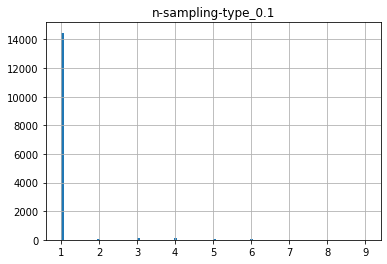

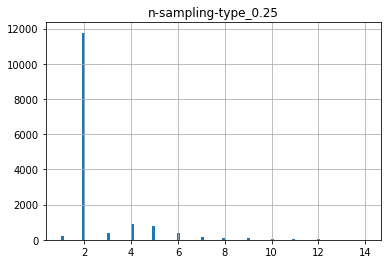

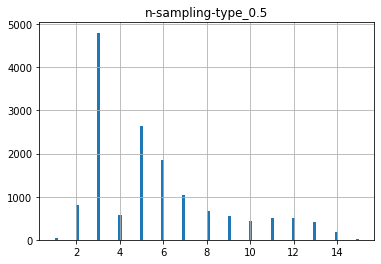

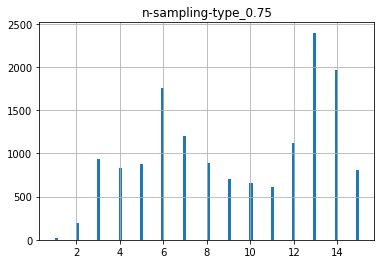

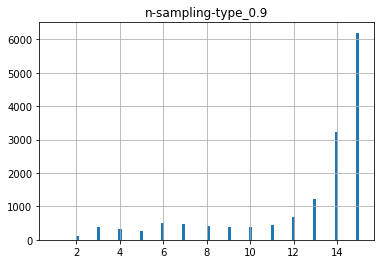

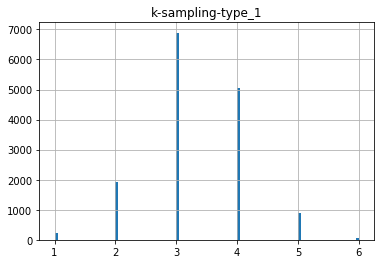

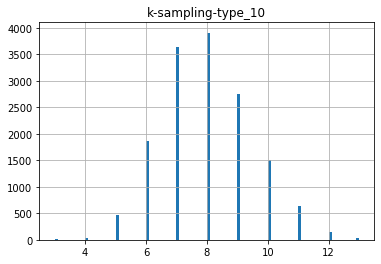

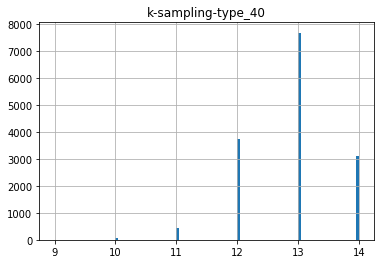

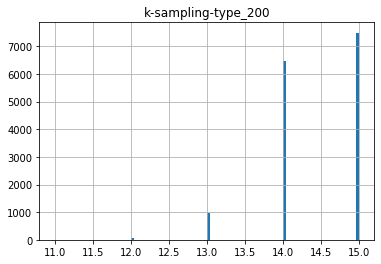

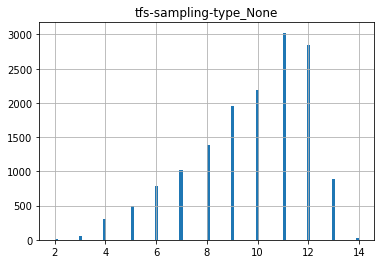

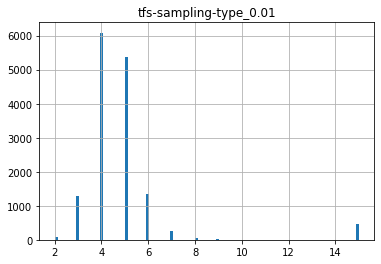

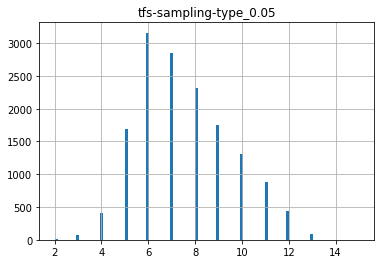

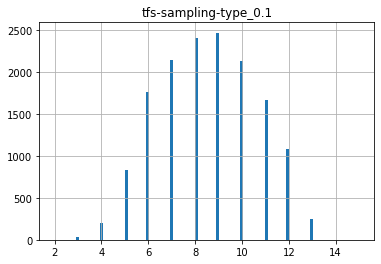

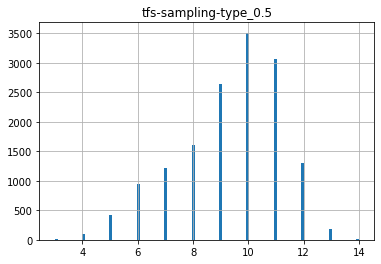

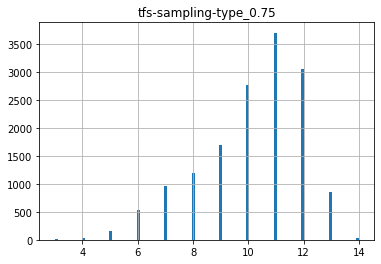

In [42]:
for c in tail_id_df_ranking.columns: 
    
    tail_id_df_ranking[c].hist(bins=100)
    plt.title(c)
    plt.show()

In [45]:
tail_cdf_df.head()

,n-sampling-type_0.1,n-sampling-type_0.25,n-sampling-type_0.5,n-sampling-type_0.75,n-sampling-type_0.9,k-sampling-type_1,k-sampling-type_10,k-sampling-type_40,k-sampling-type_200,tfs-sampling-type_None,tfs-sampling-type_0.01,tfs-sampling-type_0.05,tfs-sampling-type_0.1,tfs-sampling-type_0.5,tfs-sampling-type_0.75
0,0.195557,0.301073,0.518905,0.750658,0.900142,0.195557,0.602061,0.774605,0.906291,0.708745,0.301073,0.646504,0.678875,0.698433,0.703658
1,0.224044,0.352960,0.556938,0.756891,0.900081,0.224044,0.872809,0.945126,0.975957,0.863986,0.461498,0.609484,0.644702,0.675860,0.675860
2,0.274589,0.363976,0.570778,0.783390,0.901561,0.274589,0.700612,0.818081,0.901551,0.771999,0.394901,0.703124,0.738674,0.773599,0.778853
3,0.486848,0.256738,0.506252,0.750910,0.900101,0.486848,0.822745,0.939115,0.981008,0.466450,0.486848,0.523056,0.562913,0.596629,0.601805
4,0.645843,0.470392,0.502961,0.809627,0.900201,0.645843,0.460595,0.683131,0.854372,0.921489,0.645843,0.714389,0.752935,0.789258,0.789258


In [46]:
tail_cdf_df.shape

(15000, 15)

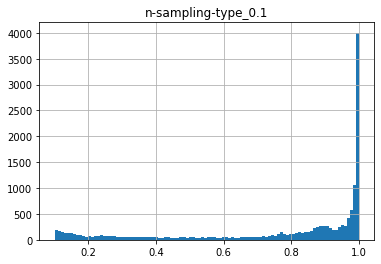

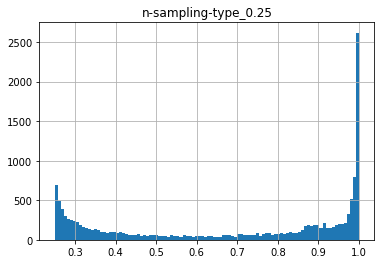

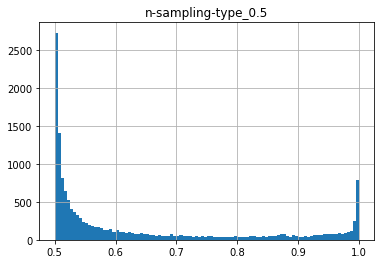

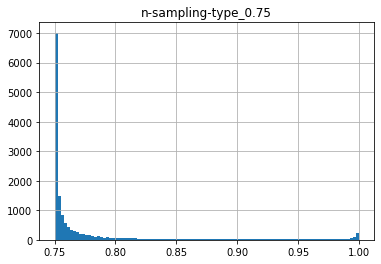

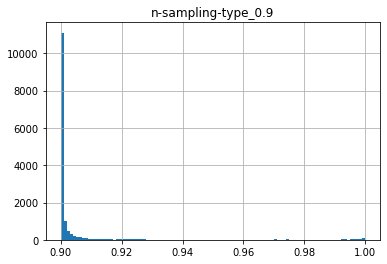

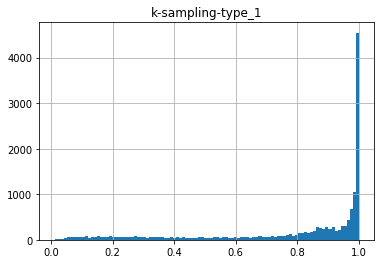

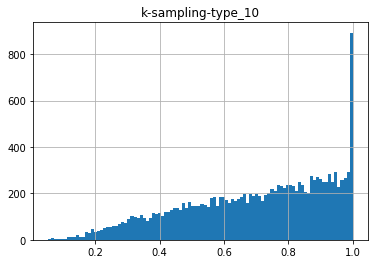

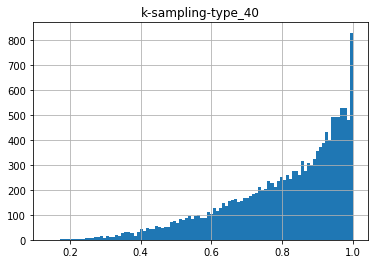

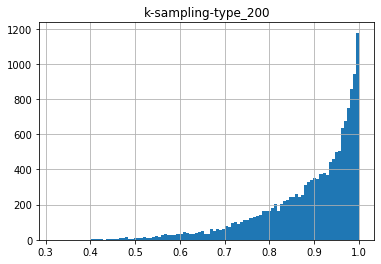

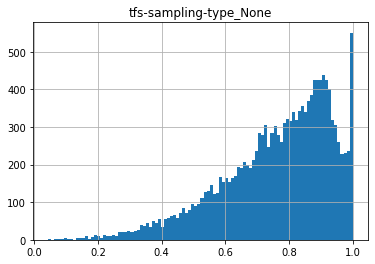

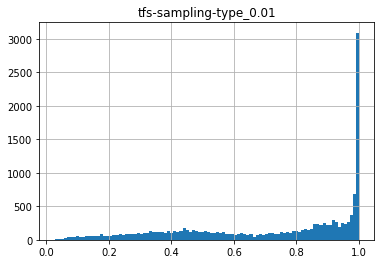

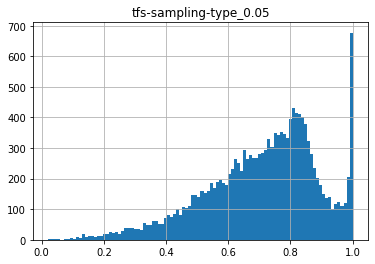

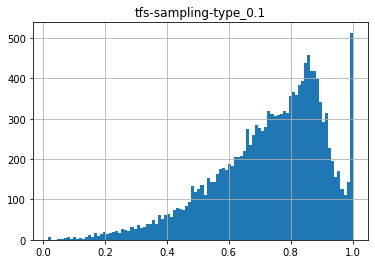

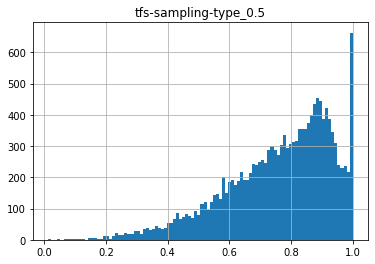

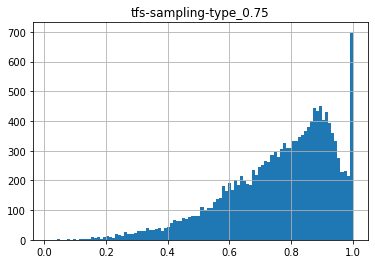

In [44]:
for c in tail_cdf_df.columns: 
    
    tail_cdf_df[c].hist(bins=100)
    plt.title(c)
    plt.show()

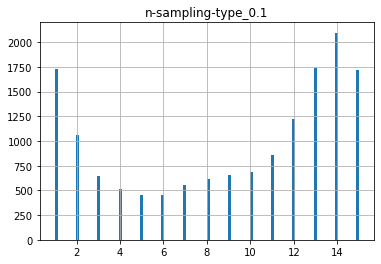

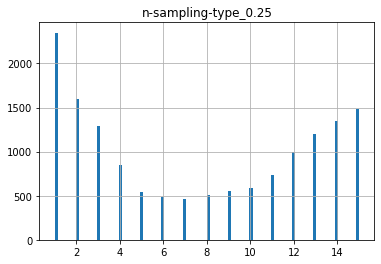

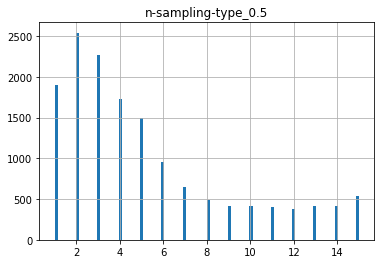

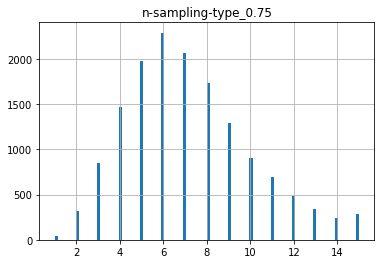

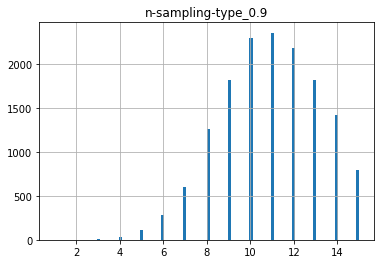

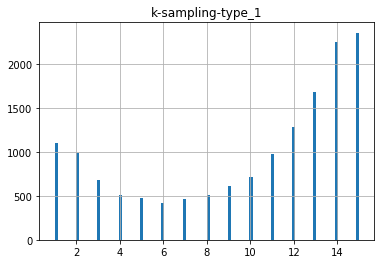

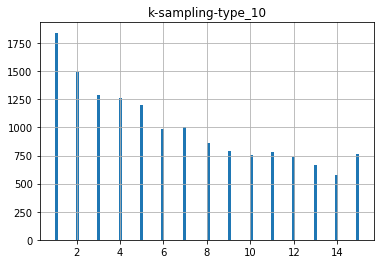

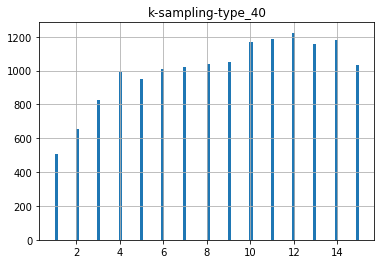

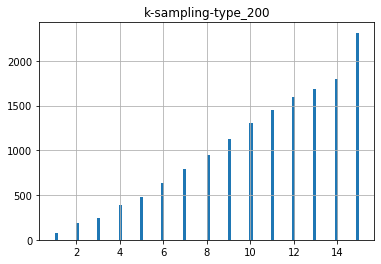

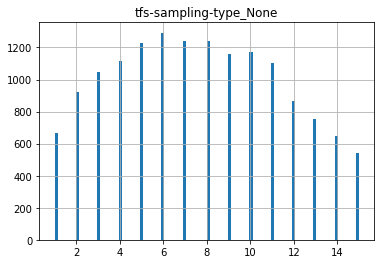

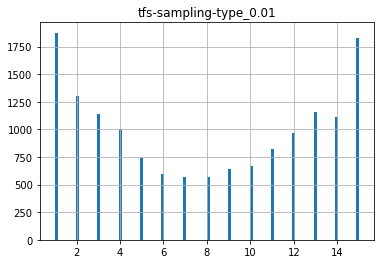

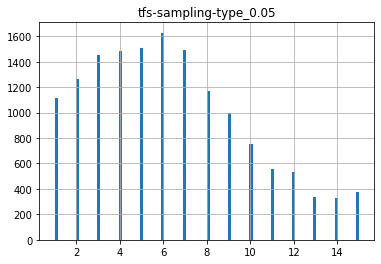

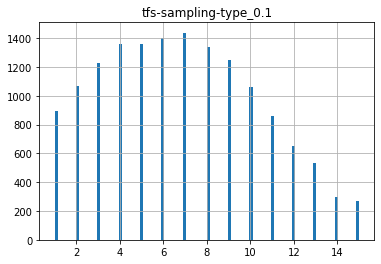

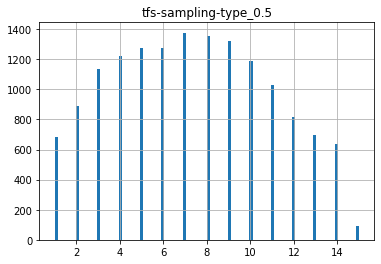

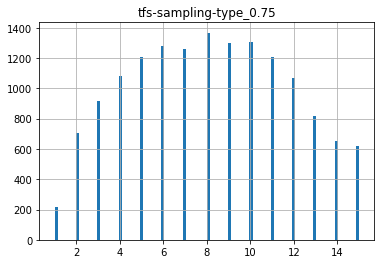

In [43]:
for c in tail_cdf_df_ranking.columns: 
    
    tail_cdf_df_ranking[c].hist(bins=100)
    plt.title(c)
    plt.show()